In [1]:
import keras
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
keras.device("cpu")
tf.device("cpu")

In [2]:
def convert_pixel_id_to_nla(pixel_id: np.ndarray, padding_value: int = -1) -> np.ndarray:
    nla = np.full((*pixel_id.shape, 4), padding_value, dtype=np.int32)
    valid_mask = pixel_id != padding_value

    chip_id = pixel_id // 2**16
    station = chip_id // 2**12
    layer = ((chip_id // 2**10) % 4) + 1
    phi = ((chip_id // 2**5) % 2**5) + 1
    z_prime = chip_id % 2**5

    z = np.where(layer == 3, z_prime - 7, np.where(layer == 4, z_prime - 6, z_prime))

    station_mask = (station == 0)
    valid_mask = valid_mask & station_mask

    nla[valid_mask, 0] = station[valid_mask]
    nla[valid_mask, 1] = layer[valid_mask]
    nla[valid_mask, 2] = phi[valid_mask]
    nla[valid_mask, 3] = z[valid_mask]

    return nla

def convert_nla_to_location(nla: np.ndarray, padding_value: int = -1) -> np.ndarray:
    location = np.full((*nla.shape[:-1], 3), padding_value, dtype=np.float64)
    valid_mask = ~(nla[:,:, ] == padding_value).any(axis=-1)
    layer = nla[:, : , 1]
    phi = nla[:, : , 2]
    z = nla[:, : , 3]
    #### Define the paramters of the detector layers
    r_layer_1 = 23.3
    r_layer_2 = 29.8
    r_layer_3 = 73.9
    r_layer_4 = 86.3
    length_layer_1 = 124.7
    length_layer_2 = 124.7
    length_layer_3 = 351.9
    length_layer_4 = 372.6
    nz_layer_1 = 6
    nz_layer_2 = 6
    nz_layer_3 = 17
    nz_layer_4 = 18

    nphi_layer_1 = 8
    nphi_layer_2 = 10
    nphi_layer_3 = 24
    nphi_layer_4 = 28

    #### Calculate the z-coordinate in the detector
    location[layer == 1, 2] = ((z[layer == 1])/ nz_layer_1 - 0.5 ) * length_layer_1
    location[layer == 2, 2] = ((z[layer == 2])/ nz_layer_2 - 0.5 ) * length_layer_2
    location[layer == 3, 2] = ((z[layer == 3])/ nz_layer_3 - 0.5 ) * length_layer_3
    location[layer == 4, 2] = ((z[layer == 4])/ nz_layer_4 - 0.5 ) * length_layer_4

    #### Calculate the x-coordinate in the detector
    location[layer == 1, 0] = r_layer_1 * np.cos((phi[layer == 1]) / nphi_layer_1 * 2 * np.pi)
    location[layer == 2, 0] = r_layer_2 * np.cos((phi[layer == 2]) / nphi_layer_2 * 2 * np.pi)
    location[layer == 3, 0] = r_layer_3 * np.cos((phi[layer == 3]) / nphi_layer_3 * 2 * np.pi)
    location[layer == 4, 0] = r_layer_4 * np.cos((phi[layer == 4]) / nphi_layer_4 * 2 * np.pi)

    #### Calculate the y-coordinate in the detector
    location[layer == 1, 1] = r_layer_1 * np.sin((phi[layer == 1]) / nphi_layer_1 * 2 * np.pi)
    location[layer == 2, 1] = r_layer_2 * np.sin((phi[layer == 2]) / nphi_layer_2 * 2 * np.pi)
    location[layer == 3, 1] = r_layer_3 * np.sin((phi[layer == 3]) / nphi_layer_3 * 2 * np.pi)
    location[layer == 4, 1] = r_layer_4 * np.sin((phi[layer == 4]) / nphi_layer_4 * 2 * np.pi)

    return location


def load_ragged_csv_to_ndarray(file_name: str, delimiter: str = ",", fill_value = -1, max_cols = 256, dtype = int) -> np.ndarray:
    rows = []
    row_lengths = []
    with open(file_name, 'r') as file:
        for line in file:
            # Split the line by the delimiter and strip whitespace
            row = np.array([value.strip() for value in line.strip().split(delimiter) if value != ''], dtype=dtype)
            # Ensure the row has at most max_cols elements
            if len(row) > max_cols:
                continue
            rows.append(row)
            row_lengths.append(len(row))
    # Convert the list of rows to a 2D NumPy array
    ragged_array = np.full((len(rows), max_cols), fill_value, dtype=dtype)
    for i, row in enumerate(rows):
        ragged_array[i, :len(row)] = row
    return ragged_array



In [3]:
DATA_DIR = "mu3e_trigger_data"
SIGNAL_DATA_FILE = f"{DATA_DIR}/run42_sig.csv"
BACKGROUND_DATA_FILE = f"{DATA_DIR}/run42_bg.csv"

In [4]:
signal_data_ids = load_ragged_csv_to_ndarray(SIGNAL_DATA_FILE, delimiter=",", fill_value=-1, max_cols=256, dtype=int)
signal_data = convert_pixel_id_to_nla(signal_data_ids)
signal_data_location = convert_nla_to_location(signal_data)

background_data_ids = load_ragged_csv_to_ndarray(BACKGROUND_DATA_FILE, delimiter=",", fill_value=-1, max_cols=256, dtype=int)
background_data = convert_pixel_id_to_nla(background_data_ids)
background_data_location = convert_nla_to_location(background_data)

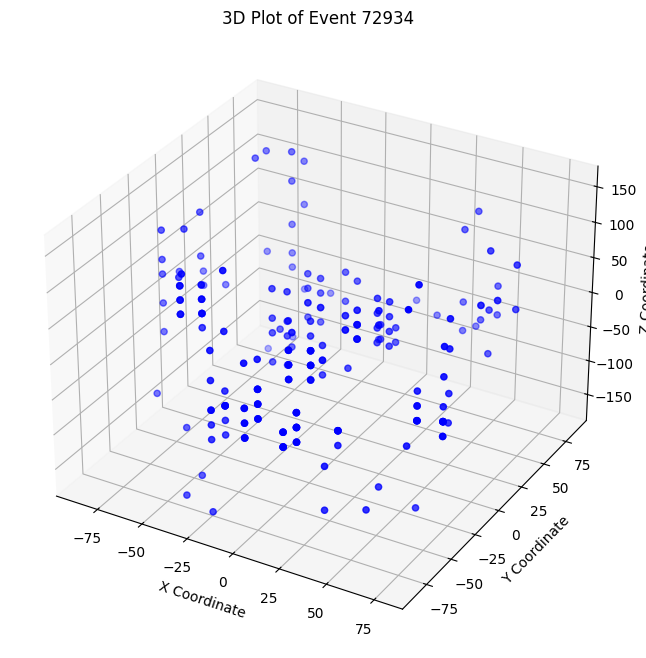

In [5]:
import matplotlib
#matplotlib.use('Qt5Agg')
hit_number = ((signal_data != -1).all(axis = -1)).sum(axis=-1)

event_index = np.argmax(hit_number)  # Index of the event to plot
event_location = signal_data_location[event_index]

# Filter out padding values
valid_mask = ~(event_location == -1).any(axis=-1)
event_location = event_location[valid_mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(event_location[:, 0], event_location[:, 1], event_location[:, 2], c='b', marker='o')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title(f'3D Plot of Event {event_index}')

plt.show()

In [6]:
class LearnedSeedVectors(keras.Model):
    def __init__(self, num_seeds, seed_dim, **kwargs):
        super(LearnedSeedVectors, self).__init__(**kwargs)
        self.seeds = tf.Variable(tf.random.normal([num_seeds, seed_dim]), trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Repeat the seeds for each batch element
        seeds = tf.repeat(self.seeds[tf.newaxis, :, :], batch_size, axis=0)
        return seeds

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seeds.shape[0], self.seeds.shape[1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seeds.shape[0], self.seeds.shape[1])

class GenerateMask(keras.Model):
    def __init__(self, padding_value = -1, **kwargs):
        super(GenerateMask, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs):
        mask = tf.not_equal(inputs, self.padding_value)
        return tf.reduce_any(mask, axis=-1, keepdims=True)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (input_shape[-1],)

class MaskOutput(keras.layers.Layer):
    def __init__(self, padding_value=-1, **kwargs):
        super(MaskOutput, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = tf.cast(mask, inputs.dtype)
            
            inputs = inputs * mask
            inputs = inputs + (1 - mask) * self.padding_value
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

class GetSequenceLength(keras.layers.Layer):
    def __init__(self, padding_value=-1, **kwargs):
        super(GetSequenceLength, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs):
        mask = tf.cast(inputs, tf.int32)
        mask = tf.squeeze(mask, axis=-1)  # Remove the last dimension if it exists
        return tf.reduce_sum(mask, axis=-1, keepdims=True)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)
    

class GenerateDecoderMask(keras.layers.Layer):
    def __init__(self, max_length=256, **kwargs):
        super().__init__(**kwargs)
        self.max_length = max_length

    def call(self, inputs):
        # inputs: shape (batch_size, 1) or (batch_size,)
        predicted_seq_length = tf.cast(tf.round(tf.squeeze(inputs, axis=-1)), tf.int32)
        # clip to max_length
        predicted_seq_length = tf.clip_by_value(predicted_seq_length, 0, self.max_length)
        # create sequence mask
        mask = tf.sequence_mask(predicted_seq_length, maxlen=self.max_length, dtype=tf.bool)
        # expand dims to (batch_size, max_length, 1)
        return tf.expand_dims(mask, axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.max_length, 1)


In [7]:
from keras.losses import Loss
from keras.metrics import Metric

class ChamferDistanceMasked(Loss):
    def __init__(self, padding_val=-1.0, name='chamfer_distance_masked'):
        super().__init__(name=name)
        self.padding_val = padding_val

    def call(self, y_true, y_pred):
        """
        y_true: (B, N, D)
        y_pred: (B, M, D)
        """
        padding_val = self.padding_val

        # Masks: (B, N) and (B, M)
        mask_true = tf.reduce_any(tf.not_equal(y_true, padding_val), axis=-1)  # valid = True
        mask_pred = tf.reduce_any(tf.not_equal(y_pred, padding_val), axis=-1)

        # Expand dims for broadcasting
        y_true_exp = tf.expand_dims(y_true, axis=2)  # (B, N, 1, D)
        y_pred_exp = tf.expand_dims(y_pred, axis=1)  # (B, 1, M, D)

        # Compute squared distances
        diff = y_true_exp - y_pred_exp
        dist = tf.reduce_sum(tf.square(diff), axis=-1)  # (B, N, M)

        # Mask invalid distances to +inf so they are ignored in min
        mask_pred_exp = tf.expand_dims(mask_pred, axis=1)  # (B, 1, M)
        dist_true_to_pred = tf.where(mask_pred_exp, dist, tf.constant(float('inf'), dtype=dist.dtype))

        mask_true_exp = tf.expand_dims(mask_true, axis=2)  # (B, N, 1)
        dist_pred_to_true = tf.where(mask_true_exp, dist, tf.constant(float('inf'), dtype=dist.dtype))

        # Min distances
        min_true_to_pred = tf.reduce_min(dist_true_to_pred, axis=2)  # (B, N)
        min_pred_to_true = tf.reduce_min(dist_pred_to_true, axis=1)  # (B, M)

        # Zero-out invalid entries (inf) and compute mean over valid
        valid_min_true_to_pred = tf.where(mask_true, min_true_to_pred, tf.zeros_like(min_true_to_pred))
        valid_min_pred_to_true = tf.where(mask_pred, min_pred_to_true, tf.zeros_like(min_pred_to_true))

        sum_true = tf.reduce_sum(valid_min_true_to_pred)
        sum_pred = tf.reduce_sum(valid_min_pred_to_true)

        count_true = tf.reduce_sum(tf.cast(mask_true, tf.float32))
        count_pred = tf.reduce_sum(tf.cast(mask_pred, tf.float32))

        # Avoid division by zero
        mean_true_to_pred = sum_true / (count_true + 1e-8)
        mean_pred_to_true = sum_pred / (count_pred + 1e-8)

        return mean_true_to_pred + mean_pred_to_true
    
class ChamferDistanceMaskedMetric(Metric):
    def __init__(self, padding_val=-1.0, name='chamfer_distance_masked_metric'):
        super().__init__(name=name)
        self.padding_val = padding_val
        self.total_distance = self.add_weight(name='total_distance', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred):
        loss = ChamferDistanceMasked(self.padding_val)(y_true, y_pred)
        self.total_distance.assign_add(loss)
        self.count.assign_add(1)

    def result(self):
        return self.total_distance / (self.count + 1e-8)

    def reset_states(self):
        self.total_distance.assign(0.0)
        self.count.assign(0.0)


In [9]:
input = keras.Input(shape=(256, 3), name="input_layer")

latent_dim = 30

# Build encoder
mask = GenerateMask(padding_value=-1, name="mask_layer")(input)
sequence_length = GetSequenceLength(padding_value=-1, name="sequence_length_layer")(mask)
flatted_mask = keras.layers.Flatten(name="flatten_mask_layer")(mask)
input_embedding = keras.layers.Dense(8, activation='relu', name="input_embedding_layer")(input)

multi_head = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8, name="multi_head_attention_layer")(input_embedding, input_embedding, attention_mask=mask)
normalised_residual = keras.layers.LayerNormalization(name="normalised_residual_layer")(multi_head + input_embedding)
dense_layer = keras.layers.Dense(8, activation='relu', name="dense_layer")(normalised_residual)
transformer_output = keras.layers.LayerNormalization(name="transformer_output_layer")(dense_layer + normalised_residual)
seed_vectors = LearnedSeedVectors(num_seeds=1, seed_dim=latent_dim, name="seed_vectors_layer")(transformer_output)

ff_transformer_output = keras.layers.Dense(8, activation='relu', name="ff_transformer_output_layer")(transformer_output)

fixed_size_output = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8, name="fixed_size_attention_layer")(
    seed_vectors, ff_transformer_output, ff_transformer_output, value_mask=flatted_mask)

fixed_size_output = keras.layers.LayerNormalization(name="fixed_size_output_layer")(fixed_size_output + seed_vectors)
fixed_size_output = keras.layers.Dense(latent_dim, activation='relu', name="fixed_size_dense_layer")(fixed_size_output)
fixed_size_output = keras.layers.LayerNormalization(name="fixed_size_normalization_layer")(fixed_size_output + seed_vectors)

latent_output = keras.layers.Flatten(name="latent_output_layer")(fixed_size_output)



#embedded_sequence_length = keras.layers.Dense(latent_dim, activation='linear', name="embedded_sequence_length_layer")(sequence_length)

#latent_output = keras.layers.Add(name="latent_output_layer")([latent_dense_2, embedded_sequence_length])


# Decoder layers using a multi-head attention mechanism
decoder_dense_1 = keras.layers.Dense(latent_dim, activation='relu', name="decoder_dense_1_layer")(latent_output)
decoder_dense_reshape = keras.layers.Reshape((latent_dim, 1), name="decoder_dense_reshape_layer")(decoder_dense_1)
#decoder_sequence_length = keras.layers.Dense(1, activation='linear', name="decoder_sequence_length_layer")(latent_output)

#decoder_mask = GenerateDecoderMask(max_length=256, name="decoder_mask_layer")(decoder_sequence_length)

decoder_seed_vectors = LearnedSeedVectors(num_seeds=256, seed_dim=latent_dim, name="decoder_seed_vectors_layer")(decoder_dense_reshape)
decoder_attention_output = keras.layers.MultiHeadAttention(num_heads=4, key_dim=latent_dim, name="decoder_attention_layer")(
    decoder_seed_vectors, decoder_dense_reshape, decoder_dense_reshape, query_mask=keras.layers.Flatten()(mask))

# Decoder layers to expand the latent space back to the input space
decoder_dense_output = keras.layers.Dense(8, activation='relu', name="decoder_dense_output_layer")(decoder_attention_output)
decoder_output = keras.layers.Dense(3, activation='linear', name="decoder_output_layer")(decoder_dense_output)

masked_output = MaskOutput(padding_value=-1, name="masked_output_layer")(decoder_output, mask=mask)

In [10]:
autoencoder = keras.Model(inputs=input, outputs=masked_output)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=ChamferDistanceMasked(padding_val=-1.0))
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_embedding_la… │ (None, 256, 8)    │         32 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_layer          │ (None, 256, 3)    │          0 │ input_layer[0][0] │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 8)    │      1,128 │ input_embedding_… │
│ (MultiHeadAttentio… │                   │            │ input_embedding_… │
│                     │                   │            │ mask_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 8)    │          0 │ multi_head_atten… │
│                     │                   │            │ input_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalised_residua… │ (None, 256, 8)    │         16 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 256, 8)    │         72 │ normalised_resid… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 8)    │          0 │ dense_layer[0][0… │
│                     │                   │            │ normalised_resid… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_output… │ (None, 256, 8)    │         16 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seed_vectors_layer  │ (None, 1, 30)     │          0 │ transformer_outp… │
│ (LearnedSeedVector… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_transformer_out… │ (None, 256, 8)    │         72 │ transformer_outp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_mask_layer  │ (None, 768)       │          0 │ mask_layer[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fixed_size_attenti… │ (None, 1, 30)     │      2,558 │ seed_vectors_lay… │
│ (MultiHeadAttentio… │                   │            │ ff_transformer_o… │
│                     │                   │            │ ff_transformer_o… │
│                     │                   │            │ flatten_mask_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1, 30)     │          0 │ fixed_size_atten… │
│                     │                   │            │ seed_vectors_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fixed_size_output_… │ (None, 1, 30)     │         60 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fixed_size_dense_l… │ (None, 1, 30)     │        930 │ fixed_size_outpu… │
│ (Dense)             │                   │            │                 

 Total params: 13,979 (54.61 KB)

 Trainable params: 13,979 (54.61 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
training_data = signal_data_location[:20000]  # Use a subset for training
autoencoder.fit(training_data, training_data, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - loss: 1963.2018 - val_loss: 1977.9943
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - loss: 1945.9749 - val_loss: 1924.1611
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - loss: 1951.6359 - val_loss: 1925.3971
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - loss: 1953.7050 - val_loss: 1932.6545
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - loss: 1948.2994 - val_loss: 1965.7454
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - loss: 1954.7617 - val_loss: 1943.6787
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 1933.3583 - val_loss: 1918.7609
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 1926.0361 - val_loss: 1916.8007
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: 1925.1531 - val_loss: 1922.4719
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 1924.4407 - val_loss: 1918.1458


In [ ]:
# Select an event to visualize
event_index = 8  # Change this index to visualize a different event
original_event = background_data_location[event_index]

# Filter out padding values
valid_mask = ~(original_event == -1).any(axis=-1)
original_event = original_event[valid_mask]

# Get the reconstructed event from the autoencoder
reconstructed_event = autoencoder.predict(background_data_location[event_index:event_index+1])[0]
reconstructed_event = reconstructed_event

# Create a 3D plot
fig = plt.figure(figsize=(12, 6))

# Plot original event
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(original_event[:, 0], original_event[:, 1], original_event[:, 2], c='b', marker='o', label='Original')
ax1.scatter(reconstructed_event[:, 0], reconstructed_event[:, 1], reconstructed_event[:, 2], c='r', marker='^', label='Reconstructed')

ax1.set_title('Original Event')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_zlabel('Z Coordinate')
ax1.legend()


plt.tight_layout()
plt.show()

In [23]:
autoencoder.save("mu3e_trigger_model.keras")
encoder = keras.Model(inputs=autoencoder.input, outputs = latent_output)

In [28]:
AD_background_data = encoder.predict(background_data_location)
AD_signal_data = encoder.predict(signal_data_location)

3126/3126 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step


In [40]:
from sklearn.model_selection import train_test_split
AB_train_data, AB_test_data = train_test_split(AD_background_data, test_size=0.2, random_state=42)

In [49]:
import src.model.AutoEncoder as AE
from importlib import reload
reload(AE)

ae = AE.AutoEncoder(nodes = [30, 20, 10], latent_dim=10, name="mu3e_autoencoder")
ae.encoder.summary()
ae.decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,760 (6.88 KB)

 Trainable params: 1,760 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 30)             │           630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960 (3.75 KB)

 Trainable params: 960 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
ae.fit(AB_train_data, AB_train_data, epochs=100, batch_size=32)

Epoch 1/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step - loss: 0.0397
Epoch 2/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step - loss: 0.0117
Epoch 3/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - loss: 0.0117
Epoch 4/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 0.0117
Epoch 5/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step - loss: 0.0117
Epoch 6/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - loss: 0.0117
Epoch 7/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step - loss: 0.0117
Epoch 8/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step - loss: 0.0117
Epoch 9/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - loss: 0.0117
Epoch 10/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - loss: 0.0117
Epoch 11/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step - loss: 0.0117
Epoch 12/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - loss: 0.0117
Epoch 13/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - loss: 0.0117
Epoch 14/100
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step - 

In [51]:
ae.evaluate(AB_test_data, AB_test_data)

626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 0.0116


0.011663505807518959

In [52]:
ae.evaluate(AD_signal_data, AD_signal_data)

3121/3121 ━━━━━━━━━━━━━━━━━━━━ 1s 229us/step - loss: 0.0100


0.00999080017209053